### Real or Fake News using Custom-Pretrained Embeddings

In this notebook we are going to create a pytorch model using torchtext and our custom dataset that identifies fake or real news based on headlines or news content.

The dataset that we are going to use was found on [kaggle](https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection).

### Installing Helper Packages
In the following code cell we are going to install the package called ``helperfns`` that provide us with some usefull helper functions for machine learning.

In [1]:
!pip install helperfns -q

https://github.com/pytorch/text


Next we are going to install torchtext with the version of pytorch that matches it's requirements.

In [2]:
!pip install torch==2.3.0  torchtext==0.18.0 torchvision==0.18.0 torchaudio==2.3.0 -q

### Imports

In the following code cell we are going to import all the packages that we are going to use throughout this notebook

In [3]:
import warnings
warnings.filterwarnings('ignore')

import nltk
import json
import time
import torch
import os
import random
import torchtext
import spacy
import re
import en_core_web_sm
from google.colab import files

from torchtext import data
from collections import Counter
from torchtext import vocab
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_wordcloud, plot_classification_report
from helperfns.utils import hms_string
from helperfns.text import clean_sentence
from torch import nn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import torch.nn.functional as F

nltk.download('stopwords')
nltk.download('punkt')

torch.__version__, torchtext.__version__

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


('2.3.0+cu121', '0.18.0+cpu')

### Setting seeds


In the following code cell we are going to set the seed to all random operations for reproducivity.

In [4]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device
In the following code cell we are going to get ``gpu`` device if possible

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

The dataset that we are going to use was founc on kaggle:

https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection


The dataset contains two files, where each file contain the news that belongs to that class.

In [6]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']

In [7]:
!kaggle datasets download bhavikjikadara/fake-news-detection --unzip

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 40.0M/41.0M [00:02<00:00, 23.1MB/s]
100% 41.0M/41.0M [00:03<00:00, 14.2MB/s]


Let's read our dataset into a pandas dataframe.

In [8]:
true = pd.read_csv('true.csv')
fake = pd.read_csv('fake.csv')

In [9]:
true.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


Next we are going to generate the labels from our dataset, they are unlabeled, however each file contains news that belongs to that class.

> For the sake or trainig resources we are only going to consider the news titles.

In [10]:
news_data = []

for _, row in true.iterrows():
  title, text = row.title, row.text
  news_data.append({'text': title, 'label': 'true'})
  # news_data.append({'text': text, 'label': 'true'})

for _, row in fake.iterrows():
  title, text = row.title, row.text
  news_data.append({'text': title, 'label': 'fake'})
  # news_data.append({'text': text, 'label': 'fake'})

news_dataframe = pd.DataFrame(news_data)
news_dataframe.head(2)

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",true
1,U.S. military to accept transgender recruits o...,true


First let's check how labels are distributed in the dataset.

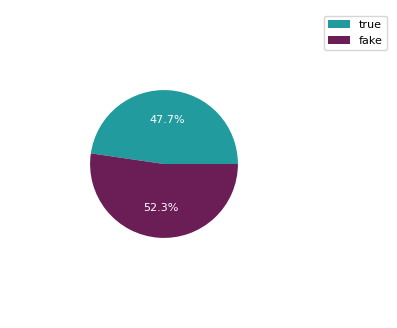

In [11]:
labels	= {i:0 for i in news_dataframe.label.unique()}
for val in news_dataframe.label:
  labels[val] += 1

plt.figure(figsize=(4, 4))
plt.pie(labels.values(), labels=labels.keys(), autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6,
        colors=['#219B9D', '#6A1E55'])
plt.legend(fontsize=8, labels=list(labels.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

As we can see that our data has unbalanced labels, so we need to balance these labels based on the class that has few examples.

In [12]:
# Separate the majority and minority classes
majority_class = news_dataframe[news_dataframe['label'] == news_dataframe['label'].value_counts().idxmax()]
minority_class = news_dataframe[news_dataframe['label'] == news_dataframe['label'].value_counts().idxmin()]

# Downsample majority class to the size of the minority class
majority_downsampled = resample(
    majority_class,
    replace=False,  # without replacement
    n_samples=len(minority_class),  # match minority class size
    random_state=SEED  # for reproducibility
)

# Combine downsampled majority and original minority
balanced_df = pd.concat([majority_downsampled, minority_class])
balanced_df.tail(3)

,text,label
21414,Minsk cultural hub becomes haven from authorities,true
21415,Vatican upbeat on possibility of Pope Francis ...,true
21416,Indonesia to buy $1.14 billion worth of Russia...,true


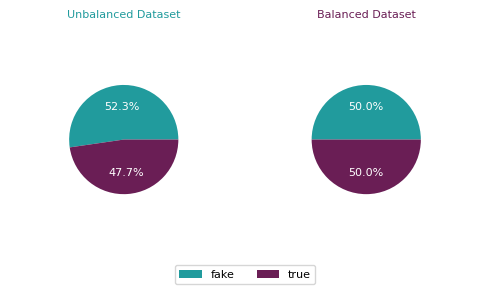

In [13]:
label_counts = news_dataframe.label.value_counts()
balanced_label = balanced_df.label.value_counts()

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

# Colors for the pie chart segments
colors = ['#219B9D', '#6A1E55']

# Plot the first pie chart
axes[0].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=0.6, colors=colors)
axes[0].set_title("Unbalanced Dataset", fontsize=8, color=colors[0])

# Plot the second pie chart
axes[1].pie(balanced_label, labels=balanced_label.index, autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=0.6, colors=colors)
axes[1].set_title("Balanced Dataset", fontsize=8, color=colors[1])

# Add a single legend for both charts
fig.legend(label_counts.index, loc="upper center", bbox_to_anchor=(0.5, 0.1), ncol=2, fontsize=8)

# Adjust layout and remove axis for a cleaner look
plt.tight_layout()
plt.show()

Next we are going to split our dataset into 3 subsets which are:

1. train
2. test
3. val

In [14]:
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=SEED)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=SEED)

### Data Analyisis

In this section of the notebook we are going to check how the data is distributed within our 3 sets.

First we are going to have a look at how the labels are distributed in the `training`, `validation` and `testing` subsets.

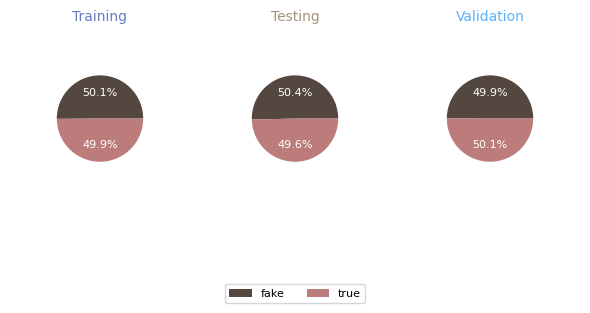

In [15]:
train_dist_label	= {i:0 for i in train_df.label.unique()}
for val in train_df.label:
  train_dist_label[val] += 1

test_dist_label	= {i:0 for i in test_df.label.unique()}
for val in test_df.label:
  test_dist_label[val] += 1

val_dist_label	= {i:0 for i in valid_df.label.unique()}
for val in valid_df.label:
  val_dist_label[val] += 1


colors = ['#54473F', '#BC7C7C']
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

axes[0].pie(train_dist_label.values(), labels=train_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=.6,
            colors=colors
            )
axes[0].set_title("Training", fontsize=10, color='#667BC6')

axes[1].pie(test_dist_label.values(), labels=test_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=.6,
            colors=colors
            )
axes[1].set_title("Testing", fontsize=10, color='#A0937D')

axes[2].pie(val_dist_label.values(), labels=val_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=.6,
            colors=colors)
axes[2].set_title("Validation", fontsize=10, color='#5AB2FF')

fig.legend(label_counts.index, loc="upper center", bbox_to_anchor=(0.5, 0.1), ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

Now we can see that there are balanced labels in all 3 sets. In the next step we are going to visualize how frequently words appears in the train, validation and test text.

In [16]:
train_text_counter = Counter()
for line in train_df.text:
    train_text_counter.update(line.lower().split())

test_text_counter = Counter()
for line in test_df.text:
    test_text_counter.update(line.lower().split())

valid_text_counter = Counter()
for line in valid_df.text:
    valid_text_counter.update(line.lower().split())

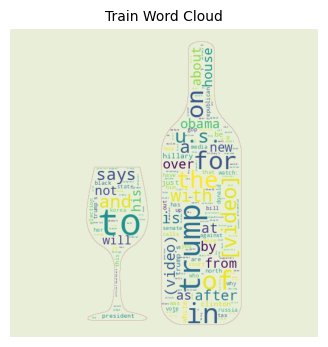

In [17]:
plot_wordcloud(train_text_counter, title="Train Word Cloud", mask="wine", background_color="#E9EED9", figsize=(4, 4),
               fontsize=10)

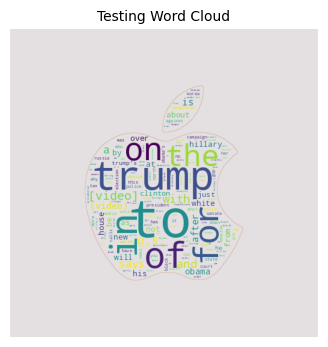

In [18]:
plot_wordcloud(test_text_counter, title="Testing Word Cloud", mask="apple", background_color="#E4E0E1", figsize=(4, 4),
               fontsize=10)

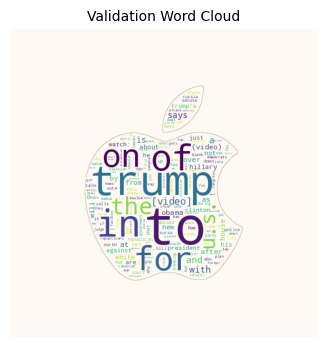

In [19]:
plot_wordcloud(valid_text_counter, title="Validation Word Cloud", mask="apple", background_color="#FEF9F2", figsize=(4, 4),
               fontsize=10)

Next let's visualize how many examples are there in each `set`.

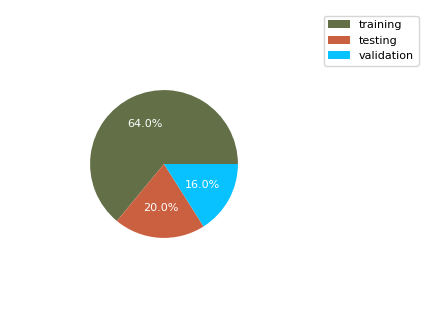

In [20]:
plt.figure(figsize=(4, 4))
plt.pie([len(train_df), len(test_df), len(valid_df)], labels=['training', 'testing', 'validation'],
        autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6,
        colors=['#626F47', '#CB6040', '#08C2FF'])
plt.legend(fontsize=8, labels=['training', 'testing', 'validation'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

``64%`` of the data is in the training set, ``20%`` in the test set and ``16%`` in the validation set. We can display this using a table:

In [21]:
columns = ["Set", "Total"]
_data = [
    ["TRAINING", f"{len(train_df):,}"],
    ["TESTING", f"{len(test_df):,}"],
    ["VALIDATION", f"{len(valid_df):,}"],
    ["TOTAL", f"{len(test_df) + len(train_df) + len(valid_df):,}"],
]
tabulate_data(columns, _data, title="SETS EXAMPLES")

SETS EXAMPLES
+------------+--------+
| Set        |  Total |
+------------+--------+
| TRAINING   | 27,413 |
| TESTING    |  8,567 |
| VALIDATION |  6,854 |
| TOTAL      | 42,834 |
+------------+--------+




### Features and Labels
Our fetures are the actual ``text`` in the dataframes which is the column named ``text`` and our labels will come from the column called `label`. In the following code cell we are going to read features and labels in a numpy arrays for each set.

In [22]:
# train
train_texts = train_df.text.values
train_labels = train_df.label.values

# test
test_texts = test_df.text.values
test_labels = test_df.label.values

# val
val_texts = valid_df.text.values
val_labels = valid_df.label.values

### Text Preprocessing

In our text processing pipeline we need to do the following steps:
1. `text_cleaning`
- First we are going to remove punctuation url's and numbers, from the text. For that we are going to use a function called `clean_sentence`  which cleans the text, by removing punctuations, numbers, tags, urls, etc from a sentence.

2. ``tokenize sentences``
* this is the process of converting a sentence or text into senquence of word. For this process we are going to use a pre-trained model from ``spacy`` language model.

3. ``vocabulary``
* We will to create a vocabulary based on our sentences that are in the train dataset. A ``vocabulary`` is esentially a word to index mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.

### Tokenizer
In the following code cell we are going to get a tokenier object that will convert a sentence into a sequence of word using the ``spacy-en`` language model. The reason we are using the english langauge model it's because our ``text`` are in ``english``.

In [23]:
tokenizer = data.utils.get_tokenizer('spacy', 'en')
tokenizer("This is a boy.")

['This', 'is', 'a', 'boy', '.']

In [24]:
def clean_sentence(sent: str, lower: bool = True) -> str:
    sent = sent.lower() if lower else sent
    sent = re.sub(
        r"(@|#)([A-Za-z0-9]+)", " ", sent
    )
    sent = re.sub(
        r"([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+", " ", sent
    )
    sent = re.sub(r"https?\S+", " ", sent, flags=re.MULTILINE)  # removing url's
    sent = re.sub(r"\d", " ", sent)  # removing none word characters
    sent = re.sub(
        r"[^\w\s\']", " ", sent
    )
    sent = re.sub(r"\s+", " ", sent).strip()  # remove more than one space
    return sent


### Vocabulary
In the following code cell we are going to create a vocabulary object from ``torchtext``.  So we are going to use the ``Counter`` module from collections to generate these counts from our ``train`` text.

We are going to specify the ``min_freq`` to ``5`` meaning that the words that does not appear at least ``5`` times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [25]:
counter = Counter()
for line in train_texts:
  line = clean_sentence(line)
  tokens = tokenizer(line)
  counter.update(tokens)

In [26]:
#  our special tokens are (unknown, padding, start of sentence, end of sentence)
vocabulary = vocab.vocab(counter, min_freq=5, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### STOI - ``String To Integer``
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called stoi which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [27]:
stoi = vocabulary.get_stoi()
print("Vocab Size: ", len(stoi))

Vocab Size:  6547


### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the ``text_pipeline`` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (``stoi``) will be converted to an unkown (``'[unk]'``) token (0).


> Note that our `text_pipeline` should also do the same process during vocabulary creation.

In [28]:
def text_pipeline(x: str):
  values = list()
  x = clean_sentence(x)
  tokens = tokenizer(x)
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### Label pipeline
Our labels for now are just textual. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a ``labels_vocab`` which is a label to integer representation.

In [29]:
labels_dict = {k: v for v, k in enumerate(train_df.label.unique())}
labels_dict

{'true': 0, 'fake': 1}

The ``label_pipeline`` function will then takes in the label and then returns us an integer representation of that label.

In [30]:
label_pipeline = lambda x: labels_dict[x]

### Pretrained vectors

In the following code cell we are going to load our own pretrained word embeddings that were trained on the news dataset. The training can be found in this notebook:

https://github.com/CrispenGari/nlp-pytorch/blob/main/14_TRAINING_EMBEDDING_USING_TORCHTEXT/00_TRAINING_WORD_EMBEDINGS.ipynb


Our embeddings were trained on `~26K` words and they are `128Dim`

In [31]:
EMBEDDING_DIM = 128

embeddings = vocab.Vectors(
    name = 'embeddings.26k.128d.txt',
    cache = 'custom_embeddings',
    unk_init = torch.Tensor.normal_
)

def get_vector(embedding, word):
    assert word in embedding.stoi, f'{word} not in the vocab'
    return embedding.vectors[embedding.stoi[word]]

### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [32]:
VOCAB_SIZE = len(stoi)
EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])
for i, word in enumerate(vocabulary.get_itos()):
  try:
    vector = get_vector(embeddings, word)
    EMBEDDING_MATRIX[i] = vector
  except AssertionError:
    pass

In the followig code cell we are going to check the embedding matrix for the word ``"people"``.

In [33]:
EMBEDDING_MATRIX[stoi['people']]

tensor([ 0.9007,  1.0645, -1.7102, -0.8220,  1.2051, -0.3436,  0.6057, -0.1324,
         1.1687, -0.5739,  0.6970, -0.2867, -1.2181,  0.8333,  1.0975,  0.7418,
        -2.2747, -1.3646, -0.7255,  0.1088, -0.1555, -0.2358, -0.3441,  0.2242,
        -0.7823, -0.2593,  0.6153, -1.2168,  0.2329, -0.8281,  0.1059,  1.0298,
         0.4966,  0.6870, -0.7548, -2.5810, -0.1706, -0.8644,  1.2117, -1.1599,
         1.2638, -0.1839,  0.8660, -0.5993,  0.5745,  0.8270,  0.0271,  0.6494,
         1.3634, -0.3579, -1.8403,  0.7032,  0.5507,  1.3438,  0.5128, -0.5085,
        -0.8731,  1.1639, -1.6503, -1.5684, -2.7237, -0.5561, -1.1861, -0.0858,
         0.8191,  1.4604,  0.3698, -0.0315,  0.2749,  1.2947, -0.8780, -0.1875,
         1.2333, -0.1306, -0.7573,  0.7821,  0.5629, -0.4811,  0.1590, -0.7964,
         1.7750, -0.7411,  0.1962, -0.5467, -0.4173,  0.5666,  0.9883,  0.7757,
        -1.9248, -1.7422, -1.0393,  0.4424,  0.2788, -0.6202,  0.8818, -0.1020,
        -0.2675, -1.6717, -0.6657, -0.54

### Creating Dataset for Training
In the following code cell we are going to create a dataset class called `FakeRealNewsDataset`. This dataset will takes in the labels and the text of a set.

In [34]:
class FakeRealNewsDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(FakeRealNewsDataset, self).__init__()
    self.labels = labels
    self.text = text

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.labels)

### ``collate_fn``
We are going to create a collate function called ``tokenize_batch``. This function actually takes in a batch and does the preprocessing of the ``text`` and ``labels``. This function will be passed to the ``DataLoader`` class to do the preprocessing of ``features`` and ``labels``.

### ``tokenize_batch`` function:

* this function takes in a batch in each set and convert the features and labels to integer representation.
* It goes ahead and ``pad`` and ``truncate`` the sequence to the same length and returns ``labels`` and ``features``.

In [35]:
def tokenize_batch(batch, max_len=128, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch long tensors since it is a multi-class classification.
  features = torch.cat(text_list, dim=0)
  return torch.FloatTensor(labels_list), features

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `FakeRealNewsDataset` class.

In [36]:
train_dataset = FakeRealNewsDataset(train_labels, train_texts)
test_dataset = FakeRealNewsDataset(test_labels, test_texts)
val_dataset = FakeRealNewsDataset(val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the ``DataLoader`` class from ``torch.utils.data`` for our ``3`` sets. We are going to use the ``batch_size`` of ``64`` and our ``collate_function`` is ``tokenize_batch``. For the validation and testing dataset we are going to set the ``shuffle`` to ``False`` because there's no need fo us to shuffle these examples.

In [37]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

Checking a single Batch Data

In [38]:
lbl, txt = next(iter(train_loader))

Labels in the first batch.

In [39]:
lbl

tensor([0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
        0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 0., 0., 1.])

The first sentence in the batch.

In [40]:
txt[0]

tensor([ 167,  603,  269,  270,    7, 4625, 1767, 2109, 5486,   13, 1069, 1070,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=torch.int32)

### Models.

Next we are going to create our model that does Fake News Detection based on the text provide.

### `FakeRealNewsBiLSTM`

In the following code cell we are going to build a model using `LSTM` layers.

In [41]:
class FakeRealNewsBiLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_size,
               hidden_size, output_size, num_layers,
               bidirectional, dropout, pad_index
               ):
    super(FakeRealNewsBiLSTM, self).__init__()
    self.embedding = nn.Sequential(
          nn.Embedding(
              vocab_size, embedding_size, padding_idx=pad_index
        )
    )

    self.lstm = nn.Sequential(
          nn.LSTM(
              embedding_size, hidden_size = hidden_size,
              bidirectional=bidirectional,
              num_layers=num_layers,
              dropout = dropout,
              batch_first=True,
          )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=output_size)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False
    )
    packed_output, (hidden, cell) = self.lstm(packed_embedded)
    if self.lstm[0].bidirectional:
      hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
    else:
      hidden = hidden[-1]
    return self.out(hidden)

In the following code cell we are going to create a 2 model instances of the `FakeRealNewsBiLSTM` model.

1. `no_embedding_model` - the model that will not use pretrained word embeddings.
2. `embedding_model` - the model that will use custom pretrained word embbedings

In [42]:
INPUT_DIM = len(stoi)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 1 if len(labels_dict) == 2 else len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['[pad]']


no_embedding_model = FakeRealNewsBiLSTM(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)

embedding_model = FakeRealNewsBiLSTM(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)

embedding_model

FakeRealNewsBiLSTM(
  (embedding): Sequential(
    (0): Embedding(6547, 128, padding_idx=1)
  )
  (lstm): Sequential(
    (0): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
  )
)

### Model Parameters

In the following code cell we are going to count parameters of each model achitecture and visualize it using a table.

In [43]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["embedding_model", *count_trainable_params(embedding_model)],
    ["no_embedding_model", *count_trainable_params(no_embedding_model)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+--------------------+--------------+------------------+
| MODEL              | TOTAL PARAMS | TRAINABLE PARAMS |
+--------------------+--------------+------------------+
| embedding_model    |    3,206,017 |        3,206,017 |
| no_embedding_model |    3,206,017 |        3,206,017 |
+--------------------+--------------+------------------+


### Loading Embedding Vectors

In the following code cells we are going to load the pretained custom vectors in our embedding layer to our models. We are going to load the embedding vectors tha suits our data using the

``model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)``

> Note that we are only going to load for the model name `embedding_model` so that we can do the comparison well.

In [44]:
embedding_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.2408,  1.2648, -0.2129,  ..., -0.7030,  1.2043, -1.5764],
        [-1.5859,  0.4090,  1.6762,  ..., -1.5110,  0.4695,  0.0798],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

### Optimizer and Criterion
In the following code cell we are going to define the ``optimizers``
for all the 2 models and a two loss functions. For the ``optimizer`` we are going to use the ``Adam`` optimizer with default parameters and for the criterion we are going to use the ``BCEWithLogitsLoss()`` function since this is a binary-class classification.

In [45]:
embedding_optimizer = torch.optim.Adam(embedding_model.parameters())
embedding_criterion = nn.BCEWithLogitsLoss().to(device)

no_embedding_optimizer = torch.optim.Adam(no_embedding_model.parameters())
no_embedding_criterion = nn.BCEWithLogitsLoss().to(device)

In the following code cell we are going to create our ``categorical_accuracy`` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [46]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  return correct.sum() / len(correct)

### Training and evaluation functions.

In the following code cell we are going to create our ``train`` and ``evalute`` functions:

In [47]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()

    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = binary_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = binary_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop.

When training the model we are going to train each model surperately. And we are also going to keep on tracking the training history of each model. The following `History` class is a data structure for our training history.

In [48]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

### 1. Training the `LSTM` model

The folloing code cell will run a training loop for `10` epochs.

In [49]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=10, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [50]:
EPOCHS = 10

embedding_history, embedding_elt, embedding_last_saved_epoch = run_train_loop(
    embedding_model, 'embedding_model_lstm.pt', train_loader, val_loader, EPOCHS,
    optimizer=embedding_optimizer, criterion=embedding_criterion
)

EPOCH: 01/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.180 |    0.924 | 0:00:33.08 |
| Validation | 0.123 |    0.953 |            |
+------------+-------+----------+------------+
EPOCH: 02/10 not saving...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.081 |    0.970 | 0:00:29.08 |
| Validation | 0.151 |    0.949 |            |
+------------+-------+----------+------------+
EPOCH: 03/10 not saving...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.048 |    0.983 | 0:00:27.02 |
| Validation | 0.140 |    0.957 |            |
+------------+-------+----------+------------+
EPOCH: 04/10 saving best model...
+------------+-------+----------

In [51]:
no_embedding_history, no_embedding_elt, no_embedding_last_saved_epoch = run_train_loop(
    no_embedding_model, 'no_embedding_model_lstm.pt', train_loader, val_loader, EPOCHS,
    optimizer=no_embedding_optimizer, criterion=no_embedding_criterion
)

EPOCH: 01/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.175 |    0.927 | 0:00:38.89 |
| Validation | 0.117 |    0.955 |            |
+------------+-------+----------+------------+
EPOCH: 02/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.081 |    0.971 | 0:00:27.30 |
| Validation | 0.102 |    0.965 |            |
+------------+-------+----------+------------+
EPOCH: 03/10 not saving...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.051 |    0.983 | 0:00:27.09 |
| Validation | 0.103 |    0.964 |            |
+------------+-------+----------+------------+
EPOCH: 04/10 not saving...
+------------+-------+----------

Next we are going to check the the last saved epoch and the total training time the models.

In [52]:
rows = [
      ['with pretrained embedding', f'{EPOCHS}',f'{embedding_last_saved_epoch}', f'{hms_string(embedding_elt)}'],
      ['without pretrained embedding', f'{EPOCHS}',f'{no_embedding_last_saved_epoch}', f'{hms_string(no_embedding_elt)}']
]
tabulate_data(["MODEL NAME", "TOTAL EPOCHS", "LAST SAVED EPOCH", "TOTAL TRAINING TIME"],
              rows, "MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH
+------------------------------+--------------+------------------+---------------------+
| MODEL NAME                   | TOTAL EPOCHS | LAST SAVED EPOCH | TOTAL TRAINING TIME |
+------------------------------+--------------+------------------+---------------------+
| with pretrained embedding    |           10 |                4 |          0:04:46.99 |
| without pretrained embedding |           10 |                2 |          0:04:47.36 |
+------------------------------+--------------+------------------+---------------------+


### Training History

In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that the model took to complete each epoch.

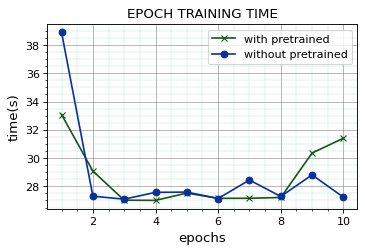

In [53]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, embedding_history.epoch_train_time, "x-", markerfacecolor = "#185519", color='#185519', label='with pretrained')
plt.plot(epochs, no_embedding_history.epoch_train_time, "o-", markerfacecolor = "#0B2F9F", color='#0B2F9F', label='without pretrained')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation loss using a line graph for each model that was observed during model training.

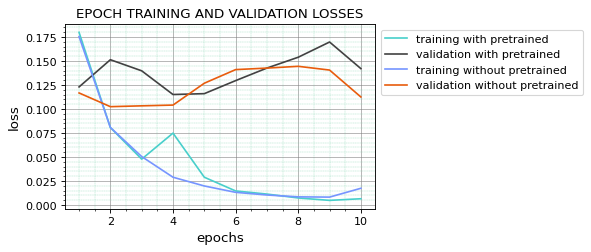

In [73]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, embedding_history.train_losses, color='#48CFCB', label='training with pretrained')
plt.plot(epochs, embedding_history.val_losses, color='#424242', label='validation with pretrained')
plt.plot(epochs, no_embedding_history.train_losses, color='#7695FF', label='training without pretrained')
plt.plot(epochs, no_embedding_history.val_losses, color='#E85C0D', label='validation without pretrained')

plt.title("EPOCH TRAINING AND VALIDATION LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation accuracies using a line graph for each model that was observed during model training.

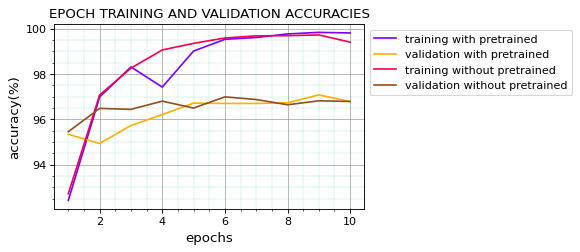

In [74]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in embedding_history.train_acc], color='#7C00FE', label='training with pretrained')
plt.plot(epochs, [acc * 100 for acc in embedding_history.val_acc], color='#FFAF00', label='validation with pretrained')

plt.plot(epochs, [acc * 100 for acc in no_embedding_history.train_acc], color='#F5004F', label='training without pretrained')
plt.plot(epochs, [acc * 100 for acc in no_embedding_history.val_acc], color='#914F1E', label='validation without pretrained')

plt.title("EPOCH TRAINING AND VALIDATION ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend(fontsize=10,  bbox_to_anchor=(1, 1), loc='upper left')

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Best model evaluations.

In the following code cell we are going to evaluate the best saved model for each model achitecture.

In [57]:
no_embedding_model.load_state_dict(torch.load('no_embedding_model_lstm.pt'))
embedding_model.load_state_dict(torch.load('embedding_model_lstm.pt'))

no_embedding_loss, no_embedding_acc = evaluate(no_embedding_model, test_loader, no_embedding_criterion)
embedding_loss, embedding_acc = evaluate(embedding_model, test_loader, embedding_criterion)

tabulate_data(
    ['MODEL', 'LOSS', 'ACCURACY'],
    [
        ['without pretrained embeddings', f"{no_embedding_loss:.3f}", f"{no_embedding_acc*100:.2f}%" ],
        ['with pretrained embeddings', f"{embedding_loss:.3f}", f"{embedding_acc*100:.2f}%"  ],
    ],
    title="MODELS' TEST LOSSES AND ACCURACIES"
)

MODELS' TEST LOSSES AND ACCURACIES
+-------------------------------+-------+----------+
| MODEL                         |  LOSS | ACCURACY |
+-------------------------------+-------+----------+
| without pretrained embeddings | 0.104 |   96.23% |
| with pretrained embeddings    | 0.102 |   96.51% |
+-------------------------------+-------+----------+


Next we are going to make predictions based with our test dataset for using our model.

In [58]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (y, X) in iterator:
      X = X.to(device)
      lengths = torch.tensor([len(i) for i in X])
      y_pred = model(X, lengths).squeeze(1)
      y_prob = F.sigmoid(y_pred).round().long()
      labels.append(y.cpu())
      predictions.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).numpy()
  return labels, predictions

with_y_true, with_y_preds = get_predictions(embedding_model, test_loader, device)
without_y_true, without_y_preds = get_predictions(no_embedding_model, test_loader, device)

### Confusion matrix

In the following code cell we are going to plot the `Confusion Matrix` for the model that have custom pretrained word embeddings.

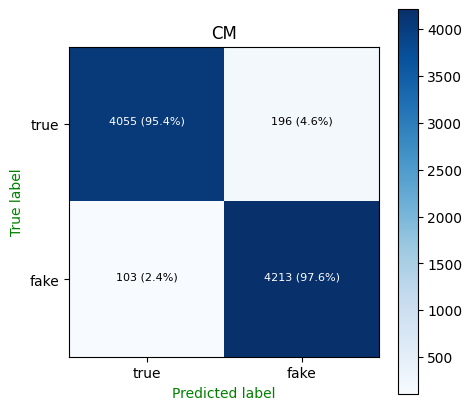

In [60]:
plot_complicated_confusion_matrix(with_y_true, with_y_preds,
  labels_dict.keys(), fontsize=8, figsize=(5, 5), title="CM"
)

In the following code cell we are going to plot the `Confusion Matrix` for the model without custom pretrained word embeddings.

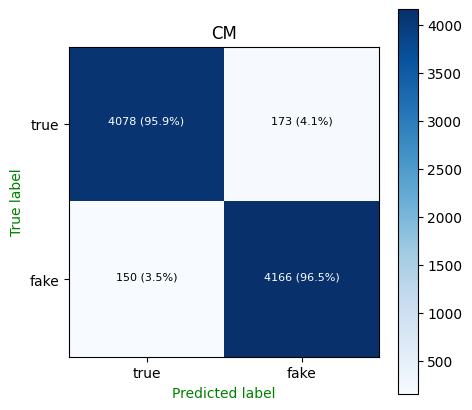

In [61]:
plot_complicated_confusion_matrix(without_y_true, without_y_preds,
  labels_dict.keys(), fontsize=8, figsize=(5, 5), title="CM"
)

### Classification Report

Next we are going to plot the classification report of our model based on the test dataset. For our two models, the one that has custom pretrained word embeddings and the one that doesn't have.

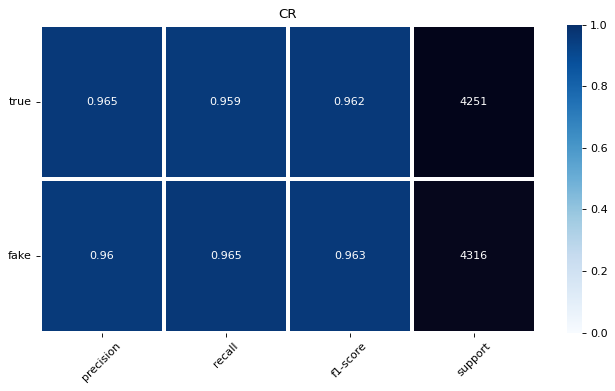

In [63]:
fig, ax = plot_classification_report(
    without_y_true, without_y_preds,
    title="CR",
    figsize=(10, 5), dpi=80,
    target_names = labels_dict.keys()
    )

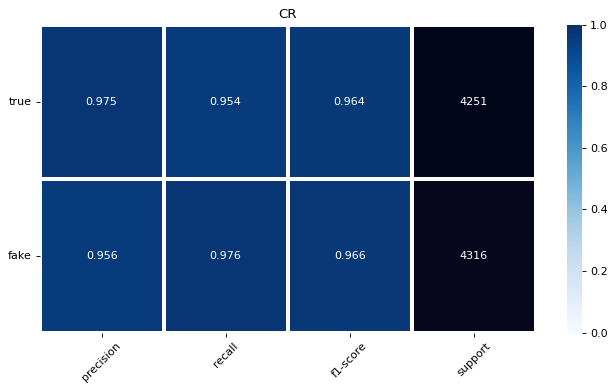

In [62]:
fig, ax = plot_classification_report(
    with_y_true, with_y_preds,
    title="CR",
    figsize=(10, 5), dpi=80,
    target_names = labels_dict.keys()
    )

### Model Inference

In this section we are going to test our modelnif it can make predictions based on the user input.

In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [64]:
def inference_preprocess_text(text, max_len=128, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

In [65]:
classes = list(labels_dict.keys())
def predict_ai(model, sentence, device):
    model.eval()
    with torch.no_grad():
      tensor = inference_preprocess_text(sentence).to(device)
      length = torch.tensor([len(t) for t in tensor])
      prob = torch.sigmoid(model(tensor, length).squeeze(0)).cpu().item()
      prediction = 1 if prob >= 0.5 else 0
      class_name = classes[prediction]
      confidence = prob if prediction == 1 else 1 - prob
      pred_data = [
          ["class_id",  prediction],
          ["class_name",  class_name],
          ["probability",  round(float(confidence), 3)],
      ]
      return dict(pred_data)

### Fake From a news Headline

In [67]:
headline = fake.title.values[0]

print("Fake Headline ", headline)
print("\n\nPrediction Model without Custom Pretrained Embeddings:")
print(predict_ai(no_embedding_model, headline, device=device))
print("\n\nPrediction Model with Custom Pretrained Embeddings:")
print(predict_ai(embedding_model, headline, device=device))

Fake Headline   Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing


Prediction Model without Custom Pretrained Embeddings:
{'class_id': 1, 'class_name': 'fake', 'probability': 1.0}


Prediction Model with Custom Pretrained Embeddings:
{'class_id': 1, 'class_name': 'fake', 'probability': 0.999}


### Fake From a news Content

In [68]:
content = fake.text.values[0]

print("Fake Content ", content)
print("\n\nPrediction Model without Custom Pretrained Embeddings:")
print(predict_ai(no_embedding_model, content, device=device))
print("\n\nPrediction Model with Custom Pretrained Embeddings:")
print(predict_ai(embedding_model, content, device=device))

Fake Content  Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of dec

###  Real News From Headline

In [70]:
headline = true.title.values[0]

print("Real Headline ", headline)
print("\n\nPrediction Model without Custom Pretrained Embeddings:")
print(predict_ai(no_embedding_model, headline, device=device))
print("\n\nPrediction Model with Custom Pretrained Embeddings:")
print(predict_ai(embedding_model, headline, device=device))

Real Headline  As U.S. budget fight looms, Republicans flip their fiscal script


Prediction Model without Custom Pretrained Embeddings:
{'class_id': 0, 'class_name': 'true', 'probability': 0.963}


Prediction Model with Custom Pretrained Embeddings:
{'class_id': 0, 'class_name': 'true', 'probability': 0.999}


### Real From news Content

In [71]:
content = true.text.values[0]

print("Real Content ", content)
print("\n\nPrediction Model without Custom Pretrained Embeddings:")
print(predict_ai(no_embedding_model, content, device=device))
print("\n\nPrediction Model with Custom Pretrained Embeddings:")
print(predict_ai(embedding_model, content, device=device))

Real Content  WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that s